# Assignment 4 - SMAI - CNN and AutoEncoders

In [2]:
import os
import sys

# enter the Foldername here:
FOLDERNAME = "/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man"

if FOLDERNAME is None or not os.path.exists(FOLDERNAME):
    FOLDERNAME = os.getcwd()

PATHNAME = f"{FOLDERNAME}"
sys.path.append(f"{FOLDERNAME}")

# DATA_FOLDER = os.path.join(FOLDERNAME, "SMAI-Dataset-release/IIIT-CFW")
DATA_FOLDER = os.path.join(FOLDERNAME, "datasets")
YAML_FOLDER = os.path.join(FOLDERNAME, "yaml-files/task-4.3")
print(DATA_FOLDER)
print(YAML_FOLDER)

/home/vanshg/play/IIIITH/sem5/smai/assignments/assignment-3-fine-man/datasets
/home/vanshg/play/IIIITH/sem5/smai/assignments/assignment-3-fine-man/yaml-files/task-4.3


In [3]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import cv2
import scipy
import scipy.io
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import wandb
import yaml

from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torch.utils.data import random_split

import torchvision
from torchvision import transforms

In [5]:
from src_torch import *
from src_torch.classifiers import *

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## (4.1) - Data Visualization and Preprocessing

### (4.1.0) - Data Loading

In [7]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# loading the MNIST data
mnist_train = torchvision.datasets.MNIST(
    root=DATA_FOLDER, train=True,
    transform=transform, download=True
)

mnist_test = torchvision.datasets.MNIST(
    root=DATA_FOLDER, train=False,
    transform=transform, download=True
)

print(f"Length of Train data: {len(mnist_train)}")
print(f"Length of Test data: {len(mnist_test)}")

Length of Train data: 60000
Length of Test data: 10000


In [11]:
# Testing some things
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(18)
])

mnist_big = torchvision.datasets.MNIST(
    root=DATA_FOLDER, train=False,
    transform=transform
)

image, label = mnist_big[0]
print(image.shape)

torch.Size([1, 64, 64])


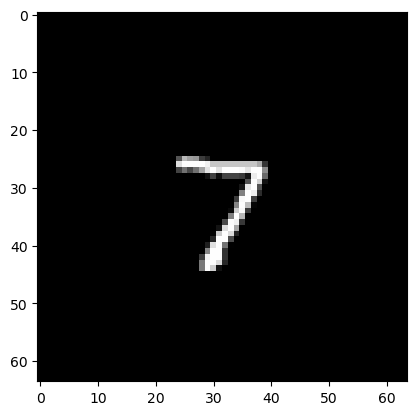

In [12]:
plt.imshow(image.squeeze(), cmap='gray')

In [9]:
out = nn.functional.pad(image, (18, 18, 18, 18))
print(out.shape)

torch.Size([1, 64, 64])


### (4.1.1) - Showing distribution of classes

In [7]:
labels = []
for data, label in mnist_train:
    labels.append(label)

labels = np.array(labels)

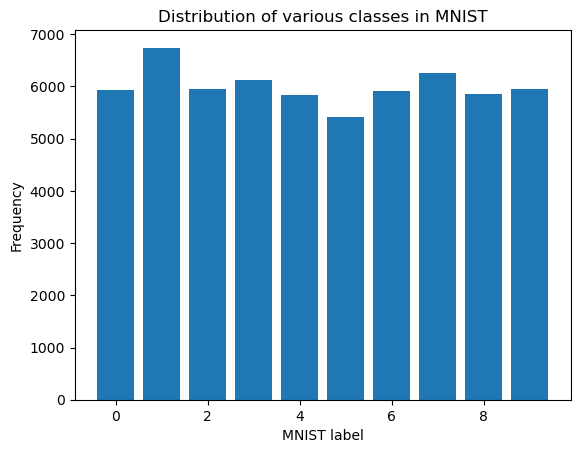

In [8]:
fig, ax = plt.subplots(1, 1)

unique_labels, label_freq = np.unique(labels, return_counts=True)

ax.bar(unique_labels, label_freq)
ax.set_title("Distribution of various classes in MNIST")
ax.set_xlabel("MNIST label")
ax.set_ylabel("Frequency")

plt.show()

```
We see that there is a slight imbalance in the distribution of classes in the Train set of MNIST. The classes 1, 3, 7 seemed to be present more than the other classes, but still the distribution of all classes is roughly uniform.
```

### (4.1.2) Visualizing samples from MNIST dataset

In [9]:
features = mnist_train.data.view(-1, 28, 28)
labels = mnist_train.targets
print(features.shape)
print(labels.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


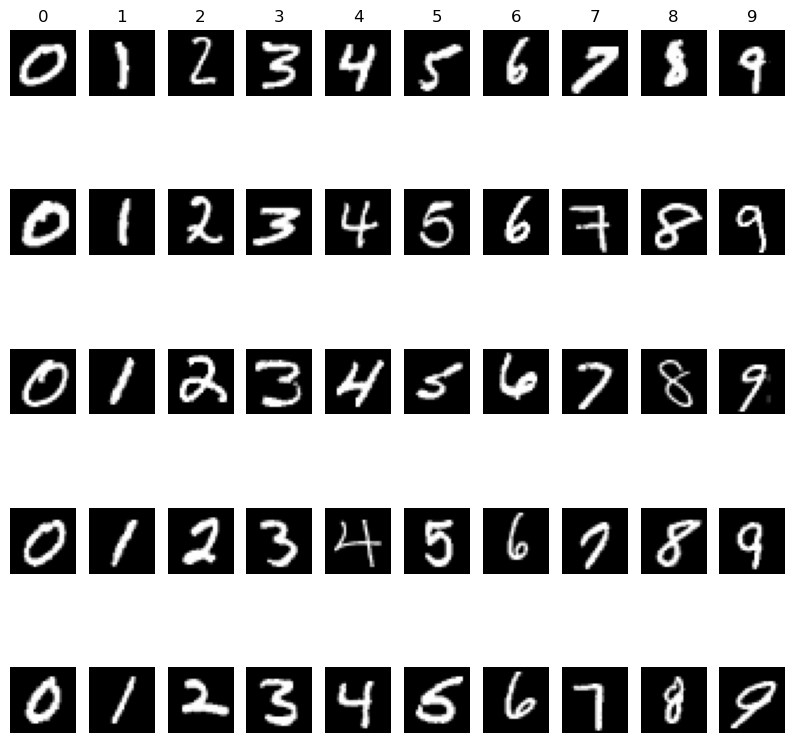

In [10]:
examples_per_class = 5
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.figure(figsize=(10, 10))
for cls_idx, cls_name in enumerate(classes):
    idxs = np.where(labels == cls_idx)[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls_idx + 1)
        plt.imshow(features[idx], cmap='gray')
        plt.axis("off")
        if i == 0:
            plt.title(f"{cls_name}")

plt.show()

### (4.1.4) Splitting data into train/val splits

In [7]:
val_ratio = 0.3
val_size = int(val_ratio * len(mnist_train))
train_size = len(mnist_train) - val_size

train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

print(f"Length of Training Data: {len(train_dataset)}")
print(f"Length of Validation Data: {len(val_dataset)}")
print(f"Length of Testing Data: {len(mnist_test)}")

Length of Training Data: 42000
Length of Validation Data: 18000
Length of Testing Data: 10000


## (4.2) Model Building

### (4.2.3) Baseline CNN model

In [12]:
untrained_model = SimpleCNN()
print(untrained_model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


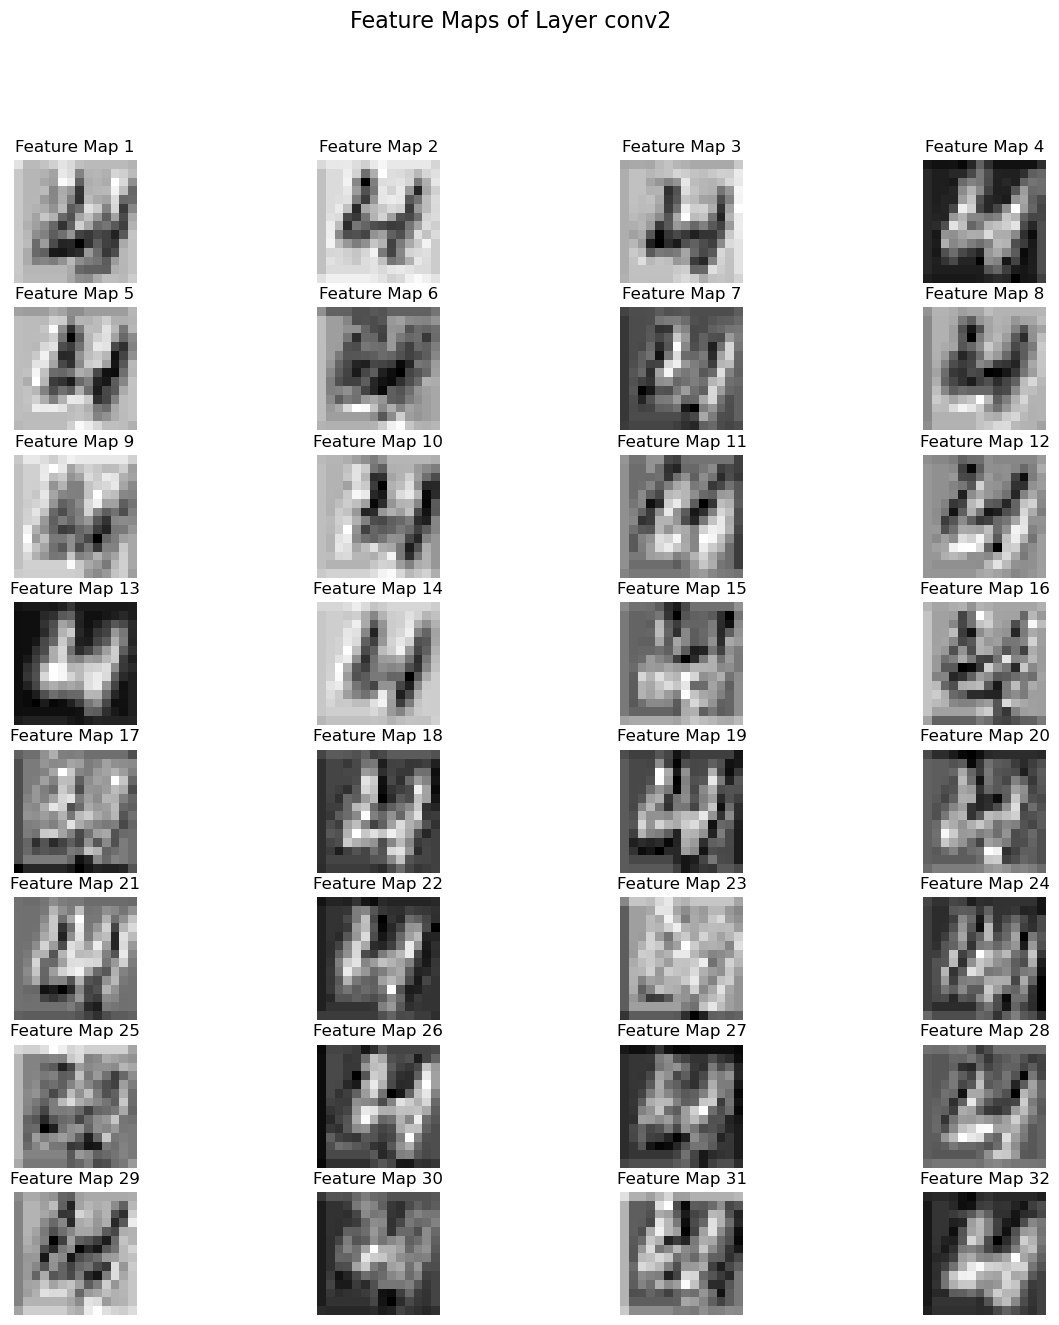

In [13]:
# Feature Maps before training
image, label = train_dataset[0]

visualize_feature_maps(untrained_model, image, 'conv2')

In [14]:
# Setup model, criterion and optimizer
model = SimpleCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

_ = train(model, criterion, optimizer, train_dataset, val_dataset, print_every=200, device='cuda')


Model is on device: cuda

Number of Iterations Per Epoch: 420
Iteration: 1/4200 | loss = 2.2940
Iteration: 200/4200 | loss = 0.1298
Iteration: 400/4200 | loss = 0.1448
Epoch: 1 | Train Accuracy: 96.540 | Val Accuracy: 96.278|  Train loss: 0.1205 | Val loss: 0.1258

Iteration: 600/4200 | loss = 0.0855
Iteration: 800/4200 | loss = 0.0986
Epoch: 2 | Train Accuracy: 97.952 | Val Accuracy: 97.522|  Train loss: 0.0690 | Val loss: 0.0779

Iteration: 1000/4200 | loss = 0.0423
Iteration: 1200/4200 | loss = 0.0266
Epoch: 3 | Train Accuracy: 98.448 | Val Accuracy: 98.011|  Train loss: 0.0515 | Val loss: 0.0633

Iteration: 1400/4200 | loss = 0.0365
Iteration: 1600/4200 | loss = 0.0663
Epoch: 4 | Train Accuracy: 98.360 | Val Accuracy: 97.983|  Train loss: 0.0530 | Val loss: 0.0645

Iteration: 1800/4200 | loss = 0.0505
Iteration: 2000/4200 | loss = 0.0657
Epoch: 5 | Train Accuracy: 98.976 | Val Accuracy: 98.367|  Train loss: 0.0369 | Val loss: 0.0526

Iteration: 2200/4200 | loss = 0.0342
Iteration:

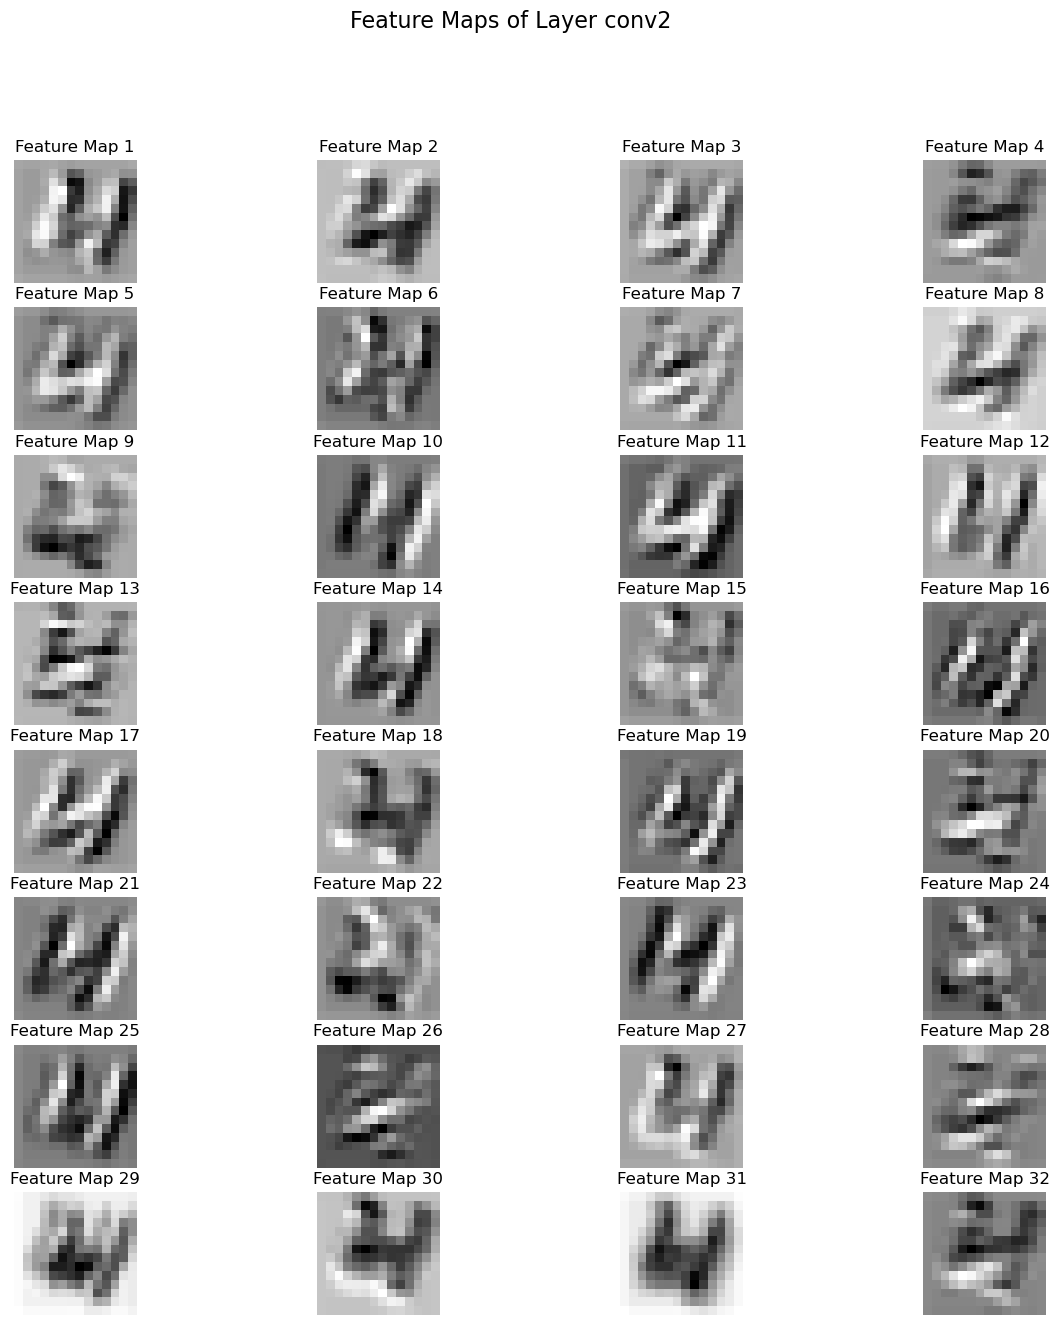

In [17]:
# Feature Maps after training
image, label = train_dataset[0]

visualize_feature_maps(model, image, 'conv2')

## (4.3) Hyper-parameter Tuning and Evaluation

In [13]:
def get_model(config):
    num_classes = config.pop("num_classes", 10)
    num_channels = config.pop("num_channels", 16)
    dropout = config.pop("dropout", 0.1)
    num_conv_layers = config.pop("num_conv_layers", 2)
    kernel_size = config.pop("kernel_size", 3)
    stride = config.pop("stride", 1)
    
    model = SimpleCNN(
        num_classes, kernel_size, stride, num_channels, dropout
    )
    return model

def get_criterion(crit_name):
    if crit_name == "CE":
        return nn.CrossEntropyLoss()
    else:
        return nn.CrossEntropyLoss()

def get_optimizer(config, model):
    lr = config["learning_rate"]
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return optimizer

def trigger_training(config, train_dataset, val_dataset):
    np.random.seed(42)
    # getting the model, criterion and optimizer
    model = get_model(config["model"])
    print(model, flush=True)
    criterion = get_criterion(config["criterion"])
    optimizer = get_optimizer(config["optimizer"], model)

    # training config
    train_config = config["training"]
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    
    train(
        model, criterion, optimizer, train_dataset, val_dataset, device=device, **train_config)
    
    return model

In [15]:
def make_wandb_run_name(config):
    model_config = config["model"]
    optim_config = config["optimizer"]
    train_config = config["training"]

    channels = model_config["num_channels"]
    kernel = model_config["kernel_size"]
    stride = model_config["stride"]
    dropout = model_config["dropout"]

    lr = optim_config["learning_rate"]
    batch = train_config["batch_size"]

    run_name = f"C{channels}-k{kernel}-s{stride}-dropout{dropout}-lr{lr}-batch{batch}"
    return run_name

In [16]:
def sweep_agent_manager():
    global train_dataset, val_dataset
    run = wandb.init()
    config = re_nest_config(dict(wandb.config))
    # setting the wandb run name for the current config
    run_name = make_wandb_run_name(config)
    print(f"Run Name: {run_name}")
    run.name = run_name
    # start the training
    trigger_training(config, train_dataset, val_dataset)

In [11]:
# testing out sweep using a single config
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "CE",
        "model": {
            "num_conv_layers": 2,
            "num_channels": 16,
            "kernel_size": 5,
            "stride": 1,
            "dropout": 0.1,
            "num_classes": 10,
        },
        "optimizer": {
            "learning_rate": 1e-2,
        },
        "training": {
            "batch_size": 100,
            "epochs": 10,
            "print_every": 100,
            "log_wandb": True,
            "verbose": True
        }
    }
}

In [ ]:
wandb.init(
    project="smai-assignment3-task4",
    config=config
)

wandb.run.name = "testing"
trigger_training(config["parameters"], train_dataset, val_dataset)
wandb.finish()

In [12]:
model = get_model(config["parameters"]["model"])
optimizer = get_optimizer(config["parameters"]["optimizer"], model)
criterion = get_criterion(config["parameters"])

print(model)
print(optimizer)
print(criterion)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
CrossEntropyLoss()


In [17]:
f = open(os.path.join(YAML_FOLDER, "two-conv-grid.yaml"), "r")

sweep_configuration = yaml.safe_load(f)
print(sweep_configuration)

{'method': 'grid', 'project': 'smai-assignment3-task4', 'name': 'two-conv-layers-grid-search', 'parameters': {'criterion': {'value': 'CE'}, 'model.conv_layers': {'value': 2}, 'model.num_channels': {'values': [32, 64, 128]}, 'model.kernel_size': {'values': [1, 3, 5]}, 'model.stride': {'values': [1, 3, 5]}, 'model.dropout': {'values': [0, 0.1, 0.25]}, 'model.num_classes': {'value': 10}, 'optimizer.learning_rate': {'values': [0.0005, 0.001, 0.01]}, 'training.batch_size': {'values': [64, 128]}, 'training.epochs': {'value': 20}, 'training.log_wandb': {'value': True}, 'training.verbose': {'value': True}, 'training.print_every': {'value': 100}}}


In [18]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="smai-assignment3-task4")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/vanshg/.netrc


Create sweep with ID: nrul5ozz
Sweep URL: https://wandb.ai/vanshg/smai-assignment3-task4/sweeps/nrul5ozz


In [ ]:
wandb.agent(sweep_id=sweep_id, function=sweep_agent_manager)

## (4.4) Model Evaluation and Analysis

### (4.4.1) Evaluating best model on Test Dataset

In [10]:
# Best Hyper-parameters found using Wandb
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "CE",
        "model": {
            "input_dim": 28,
            "conv_layers": 2,
            "num_channels": 128,
            "kernel_size": 5,
            "stride": 1,
            "dropout": 0.1,
            "num_classes": 10,
        },
        "optimizer": {
            "learning_rate": 0.001,
        },
        "training": {
            "batch_size": 64,
            "epochs": 18,
            "print_every": 100,
            "verbose": True
        }
    }
}

best_model = trigger_training(config["parameters"], train_dataset, val_dataset)

Model Type: CNN
SimpleCNN(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=12544, out_features=10, bias=True)
)
CrossEntropyLoss()

Model is on device: cuda

Number of Iterations Per Epoch: 657


Iteration: 1/11826 | loss = 2.3092
Iteration: 100/11826 | loss = 0.1633
Iteration: 200/11826 | loss = 0.1165
Iteration: 300/11826 | loss = 0.0194
Iteration: 400/11826 | loss = 0.0366
Iteration: 500/11826 | loss = 0.0286
Iteration: 600/11826 | loss = 0.0249
Epoch: 1 | Train Accuracy: 97.990 | Val Accuracy: 97.617|  Train loss: 0.0646 | Val loss: 0.0766

Iteration: 700/11826 | loss = 0.0127
Iteration: 800/11826 | loss = 0.0501
Iteration: 900/11826 | loss = 0.0629
Iteration: 1000/11826 | loss = 0.1572
Iteration: 1100/11826 | loss = 0.0758
Iteration: 1200/11826 | loss = 0.0059
Iteration: 1300/11826 | loss = 0.0101
Epoch: 2 | Train Accuracy: 99.255 | Val Accuracy: 98.811|  Train loss: 0.0237 | Val loss: 0.0384

Iteration: 1400/11826 | loss = 0.0255
Iteration: 1500/11826 | loss = 0.0009
Iteration: 1600/11826 | loss = 0.0719
Iteration: 1700/11826 | loss = 0.0058
Iteration: 1800/11826 | loss = 0.0039
Iteration: 1900/11826 | loss = 0.0026
Epoch: 3 | Train Accuracy: 99.426 | Val Accuracy: 98.839

In [11]:
test_acc, test_loss = evaluate(best_model, mnist_test)

print(f"\nTest Accuracy: {test_acc*100:.4f} | Test Loss: {test_loss:.4f}")


Test Accuracy: 99.3100 | Test Loss: 0.0309


In [12]:
y_pred, y_true = predict(best_model, mnist_test, device='cuda', return_true_labels=True)
y_pred = y_pred.numpy()
y_true = y_true.numpy()

# print(f"\nShape of Predictions: {y_preds.shape}") # (10000,)
# print(f"Shape of true labels: {true_labels.shape}") # (10000,)

print(f"\nClassification Report")
print(classification_report(y_true, y_pred))

Model is on device: cuda
Total number of iterations: 100

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### (4.4.2) - Confusion Matrix for Test Dataset

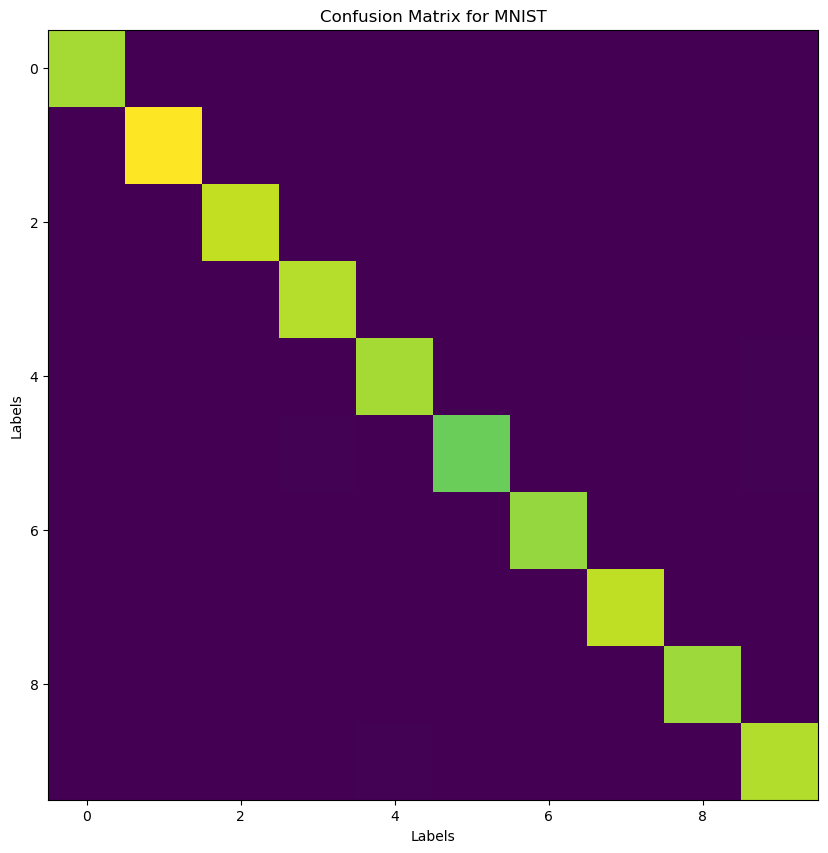

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.set_title("Confusion Matrix for MNIST")
ax.set_xlabel('Labels')
ax.set_ylabel('Labels')
ax.imshow(confusion_matrix(y_true, y_pred))

plt.show()

### (4.4.3) - Visualizing Incorrect Predictions

Number of incorrect examples: (69,)


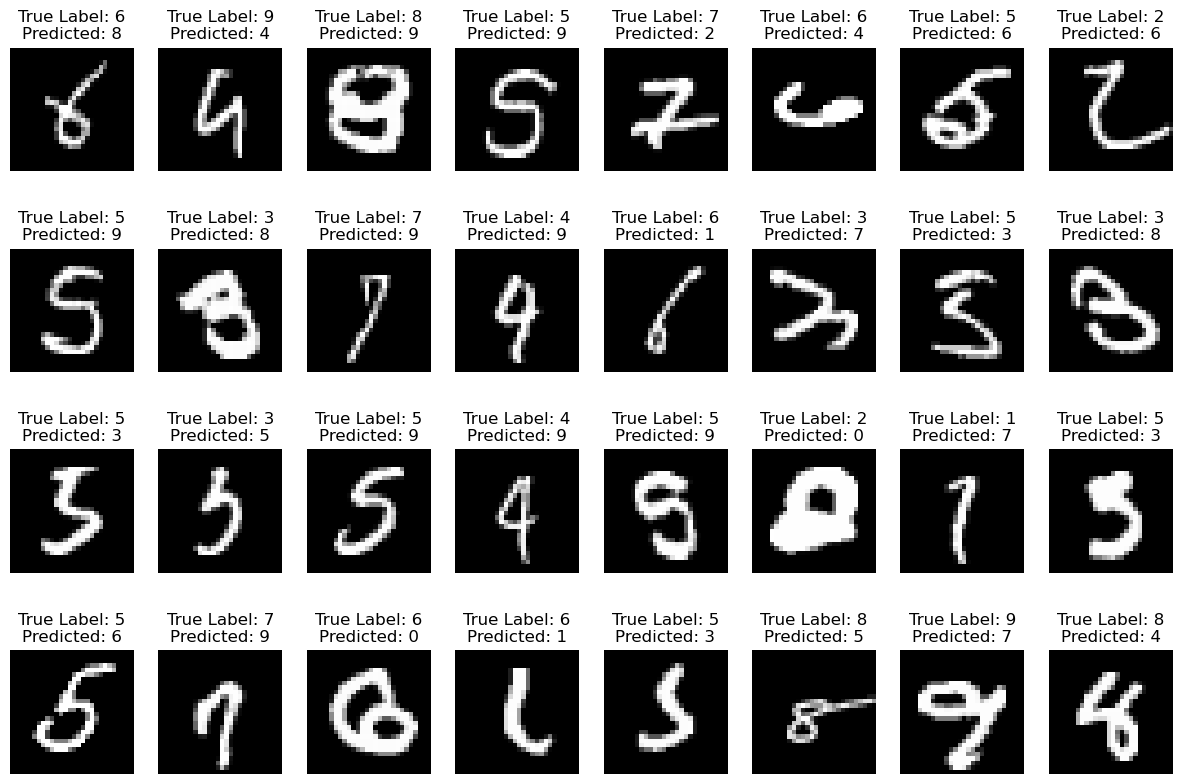

In [14]:
incorrect_idx = np.nonzero(y_pred != y_true)[0]

print(f"Number of incorrect examples: {incorrect_idx.shape}")

num_display = 32
indices = np.random.choice(incorrect_idx, num_display, replace=False)

# Number of rows to display
images_per_row = 8
num_rows = num_display // images_per_row
if num_display % images_per_row != 0:
    num_rows += 1

fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 10))
axs = axs.flatten()

for i, idx in enumerate(indices):
    predicted = y_pred[idx]
    true_label = y_true[idx]
    axs[i].set_title(f"True Label: {true_label}\nPredicted: {predicted}")
    axs[i].axis('off')
    axs[i].imshow(mnist_test[idx][0].squeeze(), cmap='gray')

plt.show()

## (4.5) Train on Noisy Dataset

### (4.5.0) - Splitting Data into Train/Val sets

In [15]:
torch.manual_seed(0)
np.random.seed(0)
noisy_mnist = scipy.io.loadmat(os.path.join(DATA_FOLDER, "mnist-with-awgn.mat"))

X_train, X_test = noisy_mnist['train_x'], noisy_mnist['test_x']
y_train, y_test = noisy_mnist['train_y'], noisy_mnist['test_y']

# Converting them to Tensors
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, 28, 28) # (N, C, H, W)
# Scaling images to bring them to range [0, 1]
X_train = X_train/255.0
y_train = torch.tensor(y_train, dtype=torch.float32)
y_train = torch.argmax(y_train, dim=1)

X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, 28, 28) # (N, C, H, W)
X_test = X_test/255.0
y_test = torch.tensor(y_test, dtype=torch.float32)
y_test = torch.argmax(y_test, dim=1)

print(f"Shape of Train Data = {X_train.shape}, {y_train.shape}, {X_train.dtype}")
print(f"Shape of Test Data: {X_test.shape}, {y_test.shape}, {X_test.dtype}")
print()

# Converting them to Pytorch Datasets
train_dataset_noisy = TensorDataset(X_train, y_train)
test_dataset_noisy = TensorDataset(X_test, y_test)

# Splitting into Train/Val splits
val_ratio = 0.3
val_size = int(val_ratio * len(X_train))
train_size = len(X_train) - val_size

train_dataset_noisy, val_dataset_noisy = random_split(train_dataset_noisy, [train_size, val_size])

print(f"Length of Training Dataset: {len(train_dataset_noisy)}")
print(f"Length of Validation Data: {len(val_dataset_noisy)}")
print(f"Length of Testing Data: {len(test_dataset_noisy)}")

Shape of Train Data = torch.Size([60000, 1, 28, 28]), torch.Size([60000]), torch.float32
Shape of Test Data: torch.Size([10000, 1, 28, 28]), torch.Size([10000]), torch.float32

Length of Training Dataset: 42000
Length of Validation Data: 18000
Length of Testing Data: 10000


### (4.5.1-2) - Training CNN on Noisy Dataset

In [71]:
torch.manual_seed(0)
np.random.seed(0)

model = SimpleCNN(dropout=0.25, num_channels=8, kernel_size=7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

_ = train(model, criterion, optimizer, train_dataset_noisy, val_dataset_noisy, device='cuda', print_every=100)


Model is on device: cuda

Number of Iterations Per Epoch: 420
Iteration: 1/4200 | loss = 2.3163
Iteration: 100/4200 | loss = 0.1421
Iteration: 200/4200 | loss = 0.1832
Iteration: 300/4200 | loss = 0.1086
Iteration: 400/4200 | loss = 0.1577
Epoch: 1 | Train Accuracy: 96.450 | Val Accuracy: 95.767|  Train loss: 0.1133 | Val loss: 0.1319

Iteration: 500/4200 | loss = 0.0878
Iteration: 600/4200 | loss = 0.2474
Iteration: 700/4200 | loss = 0.0516
Iteration: 800/4200 | loss = 0.1390
Epoch: 2 | Train Accuracy: 97.469 | Val Accuracy: 96.700|  Train loss: 0.0785 | Val loss: 0.1061

Iteration: 900/4200 | loss = 0.1757
Iteration: 1000/4200 | loss = 0.0377
Iteration: 1100/4200 | loss = 0.1200
Iteration: 1200/4200 | loss = 0.1297
Epoch: 3 | Train Accuracy: 97.802 | Val Accuracy: 96.878|  Train loss: 0.0673 | Val loss: 0.1042

Iteration: 1300/4200 | loss = 0.1158
Iteration: 1400/4200 | loss = 0.1316
Iteration: 1500/4200 | loss = 0.1056
Iteration: 1600/4200 | loss = 0.2004
Epoch: 4 | Train Accuracy:

#### Visualizing CNN features before Training on Noisy MNIST

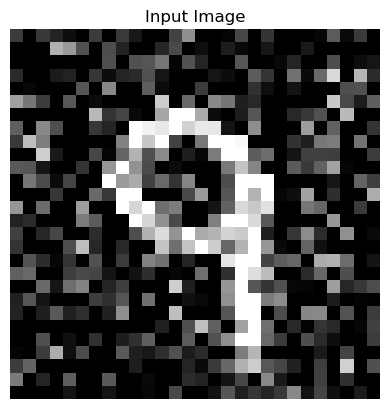

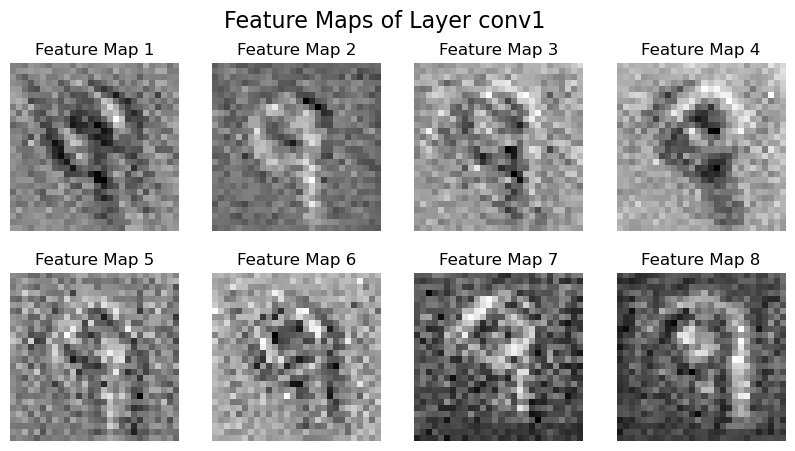

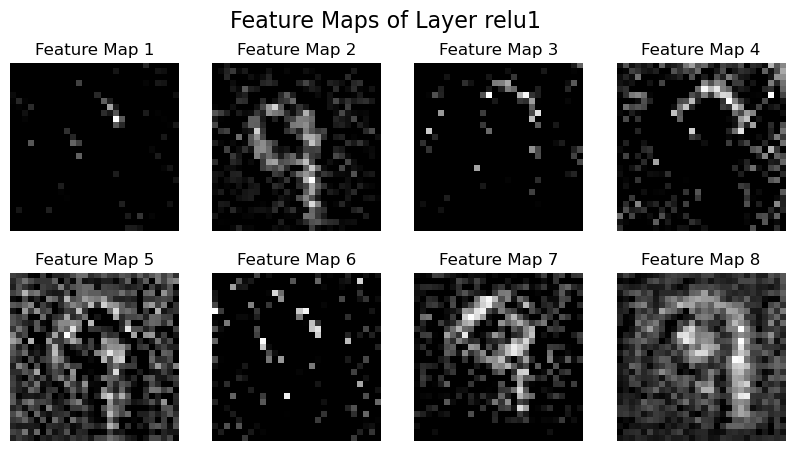

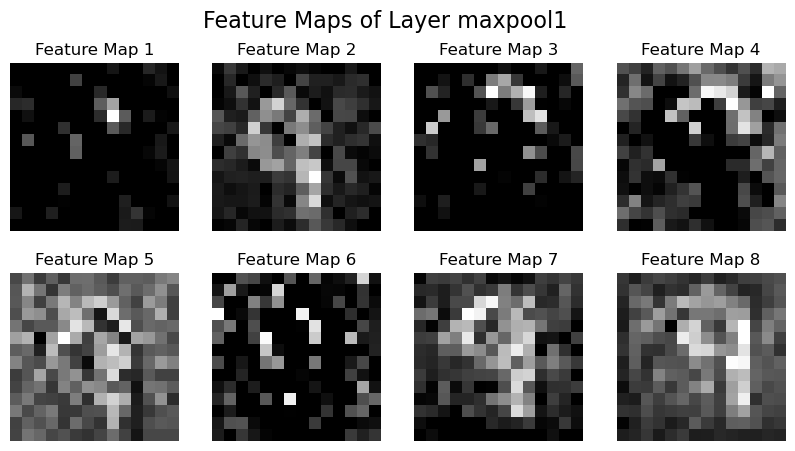

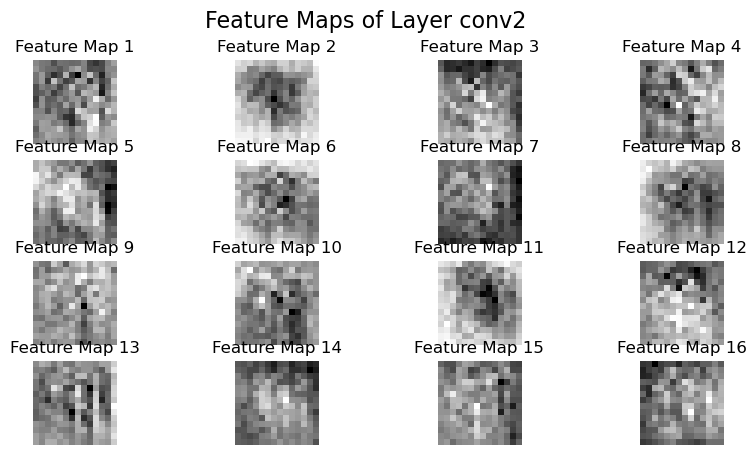

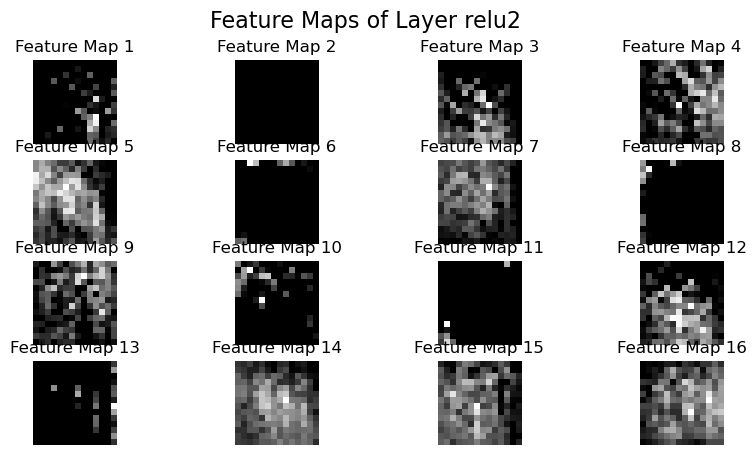

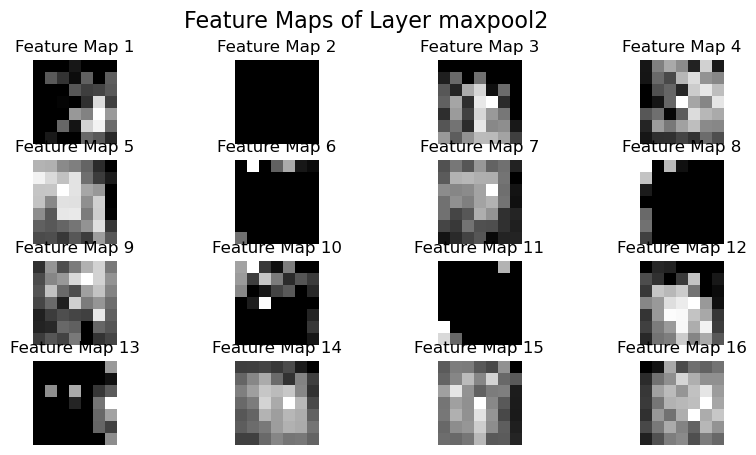

In [86]:
untrained_model = SimpleCNN(dropout=0.25, num_channels=8, kernel_size=7)
image, label = train_dataset_noisy[0]

plt.title("Input Image")
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

visualize_feature_maps(untrained_model, image, 'conv1')
visualize_feature_maps(untrained_model, image, 'relu1')
visualize_feature_maps(untrained_model, image, 'maxpool1')
visualize_feature_maps(untrained_model, image, 'conv2')
visualize_feature_maps(untrained_model, image, 'relu2')
visualize_feature_maps(untrained_model, image, 'maxpool2')

#### Visualizing Features of CNN trained on Noisy MNIST

In [72]:
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=784, out_features=10, bias=True)
)


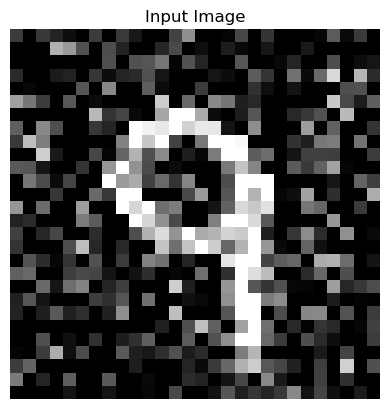

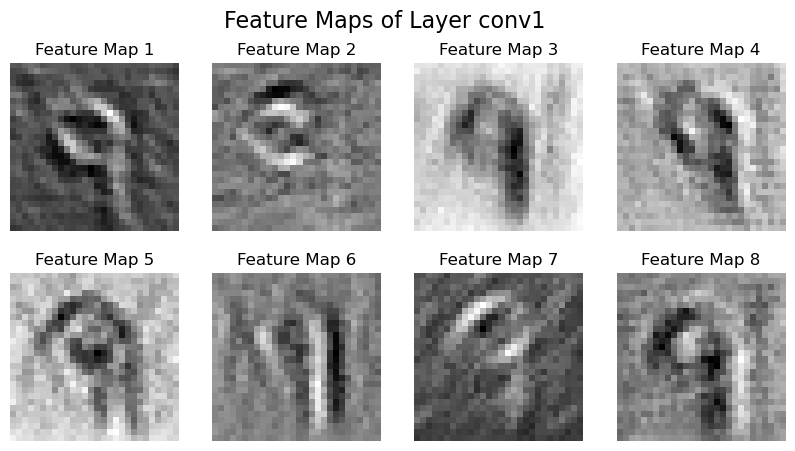

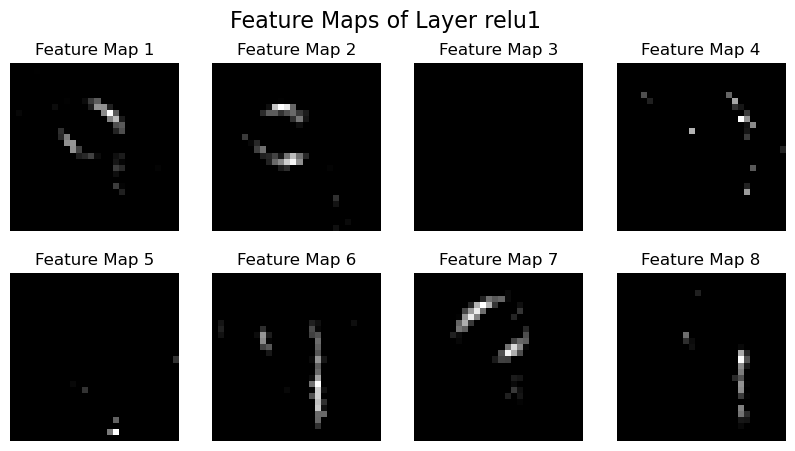

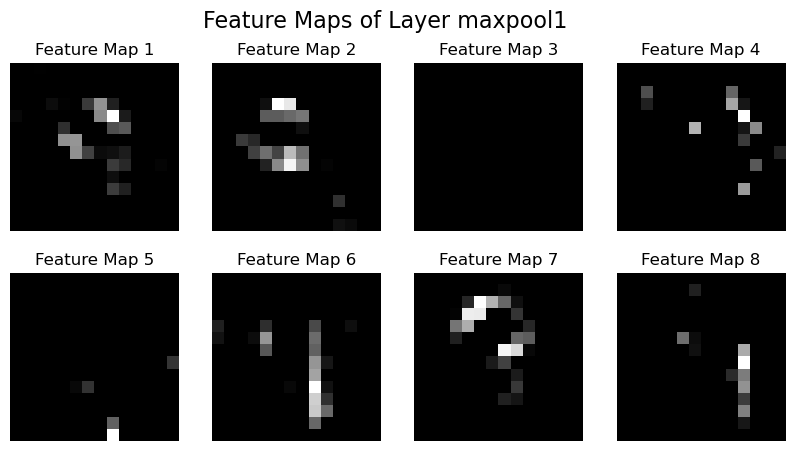

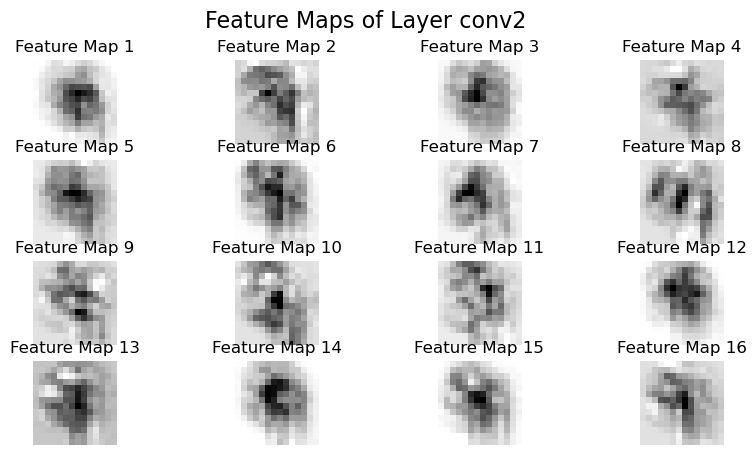

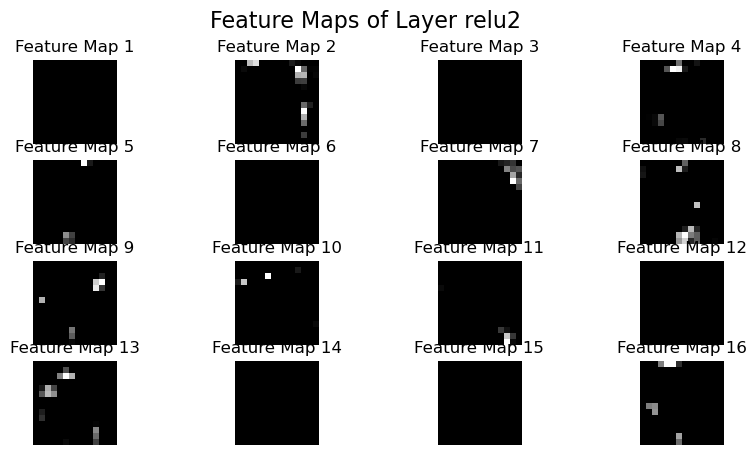

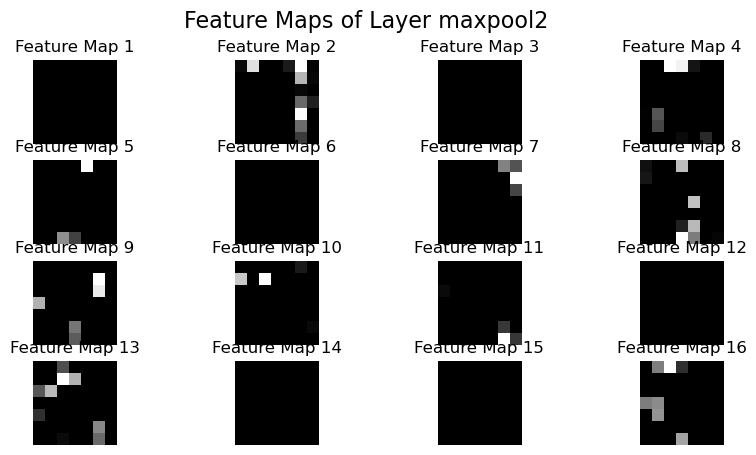

In [87]:
image, label = train_dataset_noisy[0]

plt.title("Input Image")
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

visualize_feature_maps(model, image, 'conv1')
visualize_feature_maps(model, image, 'relu1')
visualize_feature_maps(model, image, 'maxpool1')
visualize_feature_maps(model, image, 'conv2')
visualize_feature_maps(model, image, 'relu2')
visualize_feature_maps(model, image, 'maxpool2')

### (4.5.3) - Evaluating CNN on Test Set and finding Confusion Matrix

In [17]:
# Best Hyper-parameters found using Wandb
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "CE",
        "model": {
            "input_dim": 28,
            "conv_layers": 2,
            "num_channels": 128,
            "kernel_size": 5,
            "stride": 1,
            "dropout": 0.1,
            "num_classes": 10,
        },
        "optimizer": {
            "learning_rate": 0.001,
        },
        "training": {
            "batch_size": 64,
            "epochs": 18,
            "print_every": 100,
            "verbose": True
        }
    }
}

best_model_noisy = trigger_training(config["parameters"], train_dataset_noisy, val_dataset_noisy)

Model Type: CNN
SimpleCNN(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=12544, out_features=10, bias=True)
)
CrossEntropyLoss()

Model is on device: cuda

Number of Iterations Per Epoch: 657
Iteration: 1/11826 | loss = 2.2950
Iteration: 100/11826 | loss = 0.4588
Iteration: 200/11826 | loss = 0.2887
Iteration: 300/11826 | loss = 0.2055
Iteration: 400/11826 | loss = 0.3326
Iteration: 500/11826 | loss = 0.1801
Iteration: 600/11826 | loss = 0.2859
Epoch: 1 | Train Accuracy: 94.381 | Val Accuracy: 94.261|  Train loss: 0.1744 | Val loss: 0.1889

Iteration: 700/11826 | loss = 0.2850
Iteration: 800/11826 |

In [19]:
test_acc, test_loss = evaluate(best_model_noisy, test_dataset_noisy, device='cuda')
print(f"Test Accuracy: {test_acc*100:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 97.5600 | Test Loss: 0.0731


In [20]:
preds, true_labels = predict(best_model_noisy, test_dataset_noisy, device='cuda', return_true_labels=True)
preds = preds.numpy()
true_labels = true_labels.numpy()

print(f"Shape of predictions: {preds.shape}")
print(f"Shape of True labels = {true_labels.shape}")

print("Classification Report:\n")
print(classification_report(true_labels, preds))

Model is on device: cuda
Total number of iterations: 100
Shape of predictions: (10000,)
Shape of True labels = (10000,)
Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.97      0.97       892
           6       0.99      0.98      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.95      0.96      0.95      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## (4.6) - AutoEncoder for Noisy MNIST

### (4.6.0) - Generating Noisy Dataset and Training AutoEncoder

In [21]:
noisy_mnist_train = NoisyMNIST(mnist_train, autoencoder=True, std=0.25)

In [22]:
# Training the AutoEncoder on Noisy MNIST to denoise it
autoencoder_model = SimpleAutoencoder(num_channels=8, kernel_size=3, stride=1)
criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder_model.parameters(), lr=0.01)

train_config = {
    "epochs": 10,
    "print_every": 200,
    "calc_accuracy": False,
    "device": "cuda"
}

_ = train(autoencoder_model, criterion, optimizer, noisy_mnist_train, noisy_mnist_train, **train_config)


Model is on device: cuda

Number of Iterations Per Epoch: 600


Iteration: 1/6000 | loss = 0.7345
Iteration: 200/6000 | loss = 0.1287
Iteration: 400/6000 | loss = 0.1028
Iteration: 600/6000 | loss = 0.0994
Epoch: 1 |  Train loss: 0.0992 | Val loss: 0.0992

Iteration: 800/6000 | loss = 0.0980
Iteration: 1000/6000 | loss = 0.0945
Iteration: 1200/6000 | loss = 0.0970
Epoch: 2 |  Train loss: 0.0943 | Val loss: 0.0943

Iteration: 1400/6000 | loss = 0.0900
Iteration: 1600/6000 | loss = 0.0969
Iteration: 1800/6000 | loss = 0.0932
Epoch: 3 |  Train loss: 0.0926 | Val loss: 0.0926

Iteration: 2000/6000 | loss = 0.0940
Iteration: 2200/6000 | loss = 0.0911
Iteration: 2400/6000 | loss = 0.0939
Epoch: 4 |  Train loss: 0.0918 | Val loss: 0.0918

Iteration: 2600/6000 | loss = 0.0925
Iteration: 2800/6000 | loss = 0.0918
Iteration: 3000/6000 | loss = 0.0934
Epoch: 5 |  Train loss: 0.0911 | Val loss: 0.0911

Iteration: 3200/6000 | loss = 0.0880
Iteration: 3400/6000 | loss = 0.0914
Iteration: 3600/6000 | loss = 0.0917
Epoch: 6 |  Train loss: 0.0907 | Val loss: 0.0907

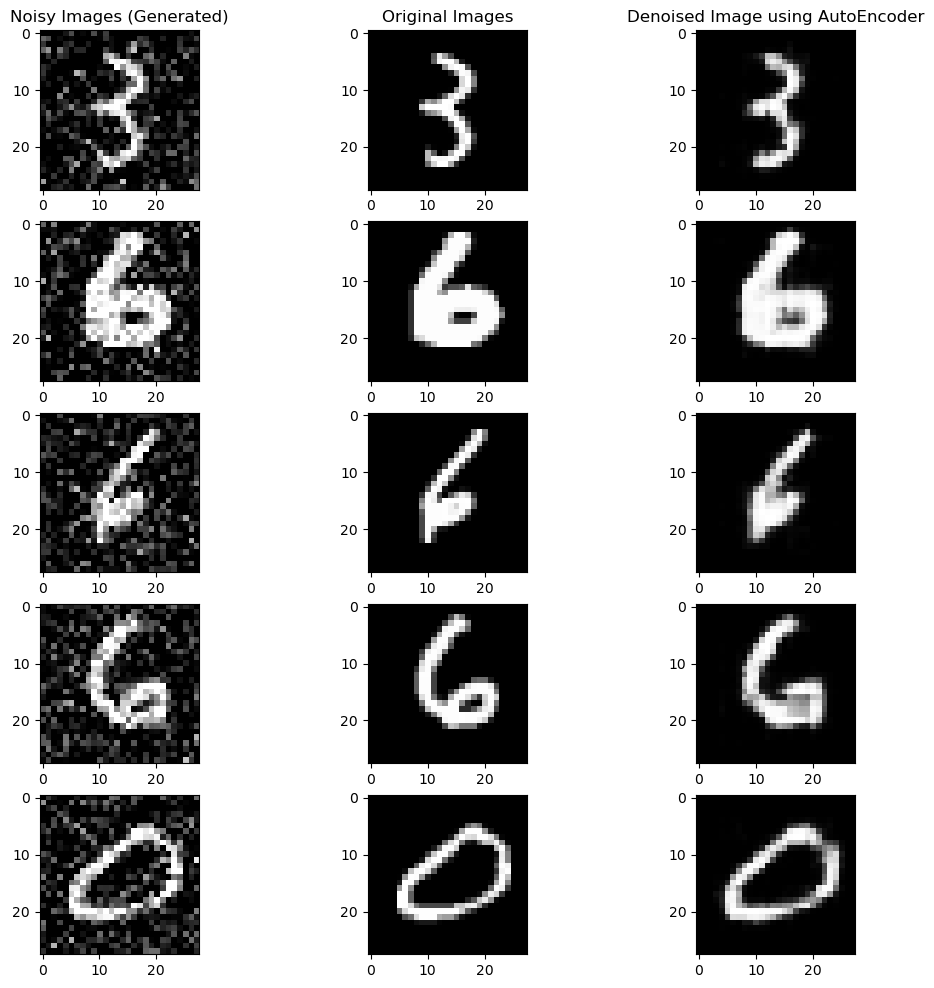

In [23]:
num_examples = len(noisy_mnist_train)
num_display = 5

fig, axs = plt.subplots(5, 3, figsize=(12, 12))
indices = np.random.choice(np.arange(num_examples), num_display, replace=False)

with torch.no_grad():
    autoencoder_model.eval()
    for i, idx in enumerate(indices):
        noisy_img, orig_img = noisy_mnist_train[idx]
        noisy_img = noisy_img.to(device)
        denoised_img = autoencoder_model(noisy_img)

        axs[i, 0].imshow(noisy_img.squeeze().cpu(), cmap='gray')
        axs[i, 1].imshow(orig_img.squeeze().cpu(), cmap='gray')
        axs[i, 2].imshow(denoised_img.squeeze().cpu(), cmap='gray')

        if i == 0:
            axs[i, 0].set_title('Noisy Images (Generated)')
            axs[i, 1].set_title('Original Images')
            axs[i, 2].set_title('Denoised Image using AutoEncoder')

plt.show()

### Visualizing Feature maps of Autoencoder

In [41]:
print(autoencoder_model)

SimpleAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


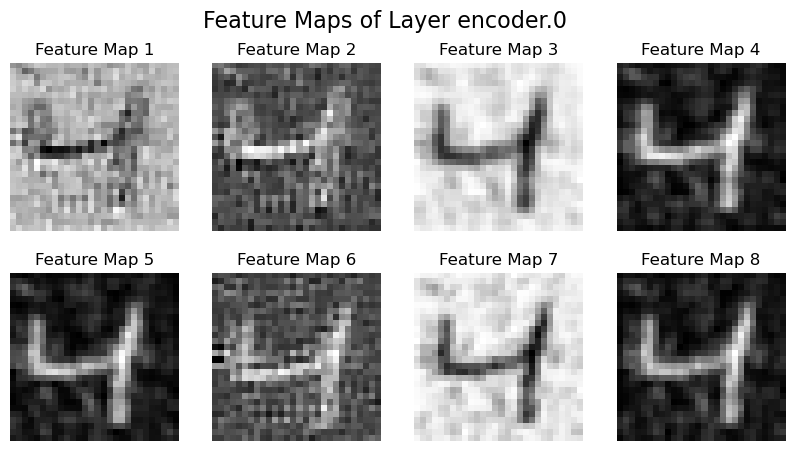

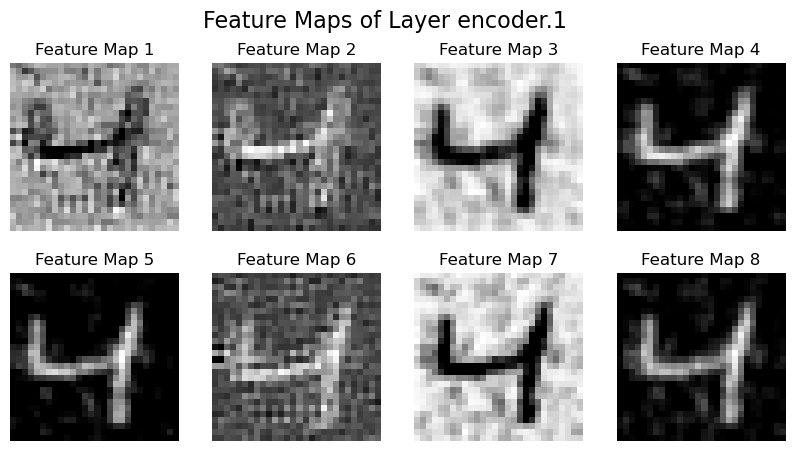

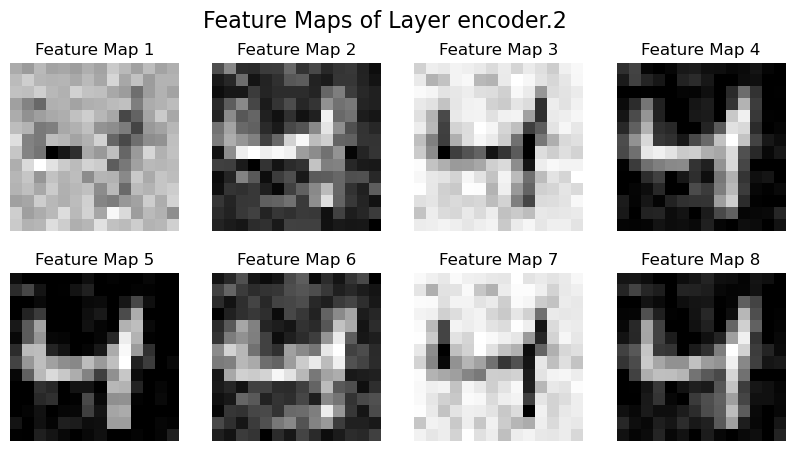

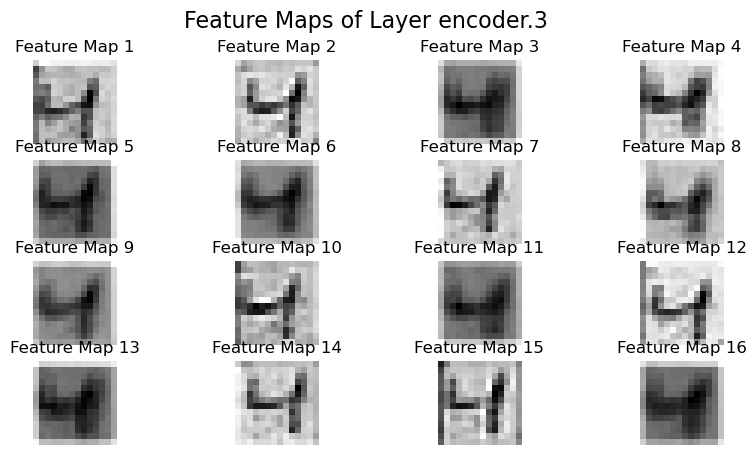

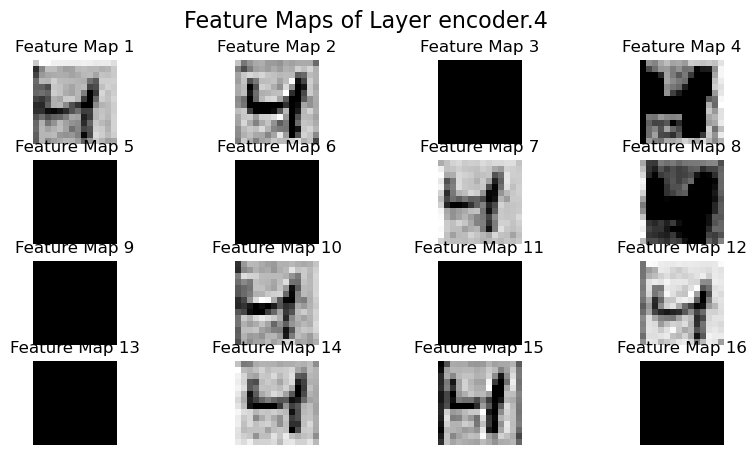

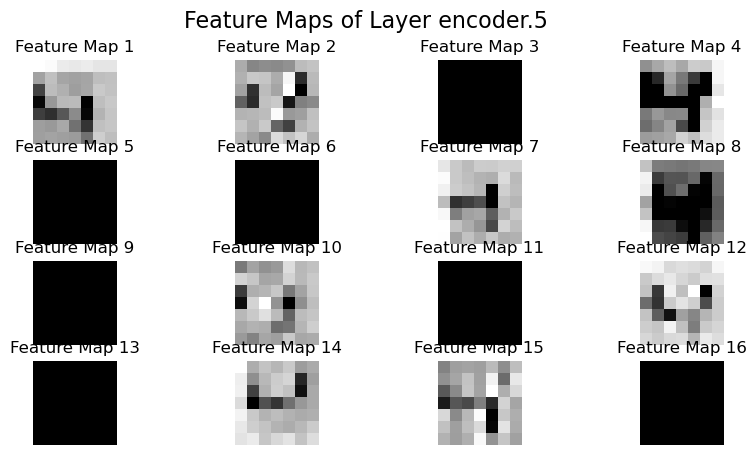

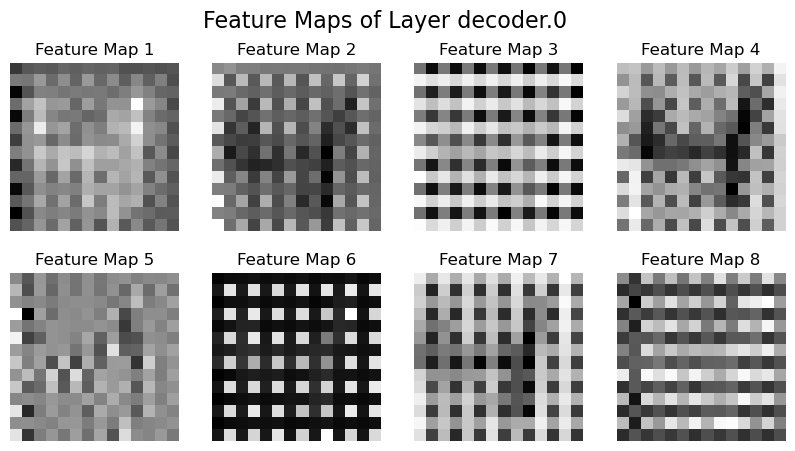

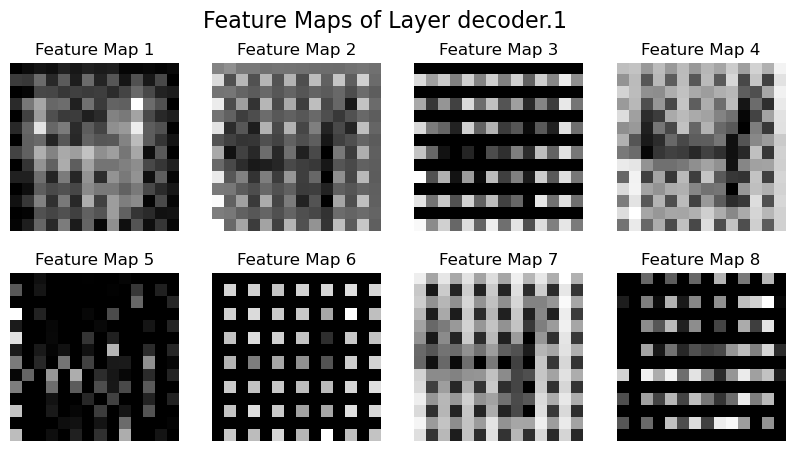

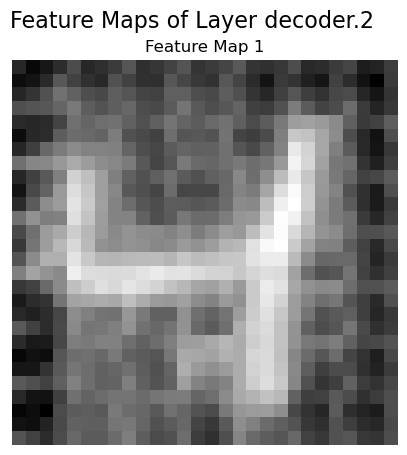

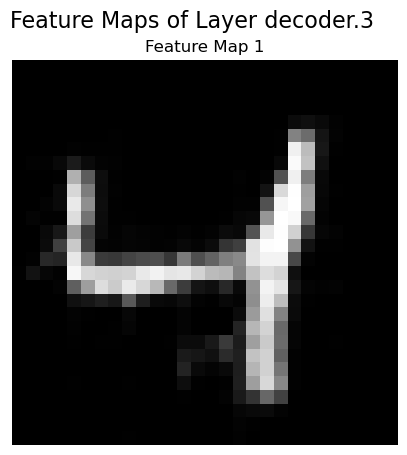

In [90]:
noisy_img, orig_img = noisy_mnist_train[2]

# Encoder
visualize_feature_maps(autoencoder_model, noisy_img, 'encoder.0')
visualize_feature_maps(autoencoder_model, noisy_img, 'encoder.1')
visualize_feature_maps(autoencoder_model, noisy_img, 'encoder.2')
visualize_feature_maps(autoencoder_model, noisy_img, 'encoder.3')
visualize_feature_maps(autoencoder_model, noisy_img, 'encoder.4')
visualize_feature_maps(autoencoder_model, noisy_img, 'encoder.5')

# Decoder
visualize_feature_maps(autoencoder_model, noisy_img, 'decoder.0')
visualize_feature_maps(autoencoder_model, noisy_img, 'decoder.1')
visualize_feature_maps(autoencoder_model, noisy_img, 'decoder.2')
visualize_feature_maps(autoencoder_model, noisy_img, 'decoder.3')

### (4.6.1) - Evaluating AutoEncoder on Noisy MNIST dataset

In [24]:
train_denoised, y_true_train = predict(autoencoder_model, train_dataset_noisy, device=device, argmax=False)
print(f"Shape of denoised Train MNIST: {train_denoised.shape}, {y_true_train.shape}\n")

val_denoised, y_true_val = predict(autoencoder_model, val_dataset_noisy, device=device, argmax=False)
print(f"Shape of denoised Val MNIST: {val_denoised.shape}, {y_true_val.shape}\n")

test_denoised, y_true_test = predict(autoencoder_model, test_dataset_noisy, device=device, argmax=False)
print(f"Shape of denoised Test MNIST: {test_denoised.shape}, {y_true_test.shape}\n")

Model is on device: cuda
Total number of iterations: 420
Shape of denoised Train MNIST: torch.Size([42000, 1, 28, 28]), torch.Size([42000])

Model is on device: cuda
Total number of iterations: 180
Shape of denoised Val MNIST: torch.Size([18000, 1, 28, 28]), torch.Size([18000])

Model is on device: cuda
Total number of iterations: 100
Shape of denoised Test MNIST: torch.Size([10000, 1, 28, 28]), torch.Size([10000])



### (4.6.2) Visualizing the Result of Denoising

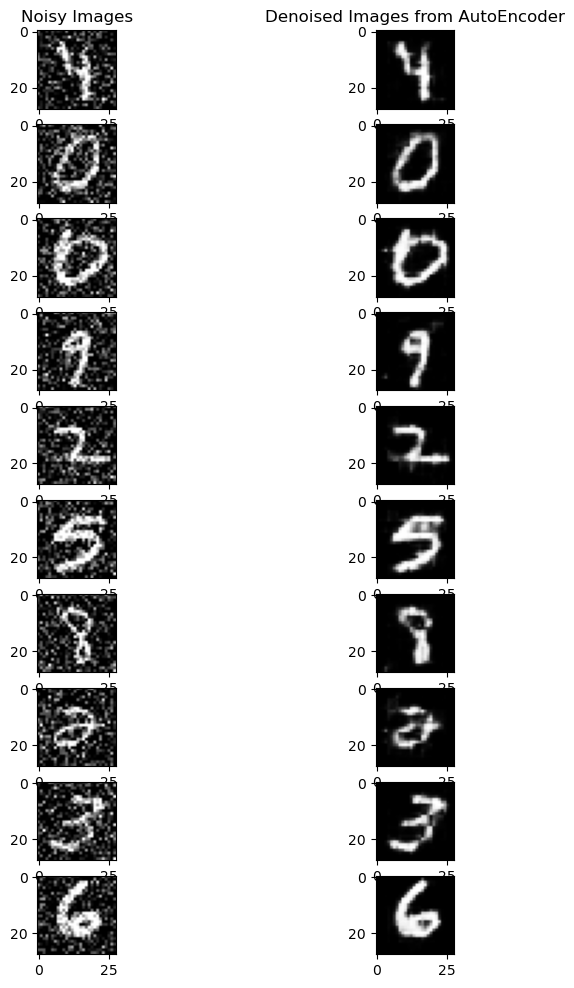

In [25]:
num_examples = len(train_dataset_noisy)
num_display = 10

fig, axs = plt.subplots(num_display, 2, figsize=(8, 12))
indices = np.random.choice(np.arange(num_examples), num_display, replace=False)

for i, idx in enumerate(indices):
    noisy_img, _ = train_dataset_noisy[idx]
    denoised_img = train_denoised[idx]

    axs[i, 0].imshow(noisy_img.squeeze().cpu(), cmap='gray')
    axs[i, 1].imshow(denoised_img.squeeze().cpu(), cmap='gray')

    if i == 0:
        axs[i, 0].set_title('Noisy Images')
        axs[i, 1].set_title('Denoised Images from AutoEncoder')

plt.show()

### (4.6.3-4) - Training CNN on Denoised Dataset

In [26]:
# Creating the Denoised dataset
denoised_train_dataset = TensorDataset(train_denoised, y_true_train)
denoised_val_dataset = TensorDataset(val_denoised, y_true_val)
denoised_test_dataset = TensorDataset(test_denoised, y_true_test)

print(f"Length of Train Dataset: {len(denoised_train_dataset)}")
print(f"Length of Val Dataset: {len(denoised_val_dataset)}")
print(f"Length of Test Dataset: {len(denoised_test_dataset)}")

Length of Train Dataset: 42000
Length of Val Dataset: 18000
Length of Test Dataset: 10000


In [27]:
# Best Hyper-parameters found using Wandb
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "CE",
        "model": {
            "input_dim": 28,
            "conv_layers": 2,
            "num_channels": 128,
            "kernel_size": 5,
            "stride": 1,
            "dropout": 0.1,
            "num_classes": 10,
        },
        "optimizer": {
            "learning_rate": 0.001,
        },
        "training": {
            "batch_size": 64,
            "epochs": 18,
            "print_every": 100,
            "verbose": True
        }
    }
}

best_model_noisy = trigger_training(config["parameters"], denoised_train_dataset, denoised_val_dataset)

Model Type: CNN
SimpleCNN(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=12544, out_features=10, bias=True)
)
CrossEntropyLoss()

Model is on device: cuda

Number of Iterations Per Epoch: 657
Iteration: 1/11826 | loss = 2.3029
Iteration: 100/11826 | loss = 0.1788
Iteration: 200/11826 | loss = 0.1203
Iteration: 300/11826 | loss = 0.1535
Iteration: 400/11826 | loss = 0.1802
Iteration: 500/11826 | loss = 0.0313
Iteration: 600/11826 | loss = 0.1705
Epoch: 1 | Train Accuracy: 96.398 | Val Accuracy: 95.822|  Train loss: 0.1127 | Val loss: 0.1344

Iteration: 700/11826 | loss = 0.0992
Iteration: 800/11826 |

### (4.6.5) - Evaluating the CNN model on Denoised Test Dataset

In [30]:
test_acc, test_loss = evaluate(model, denoised_test_dataset, device=device)
print(f"Test Accuracy: {test_acc*100:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 96.1200 | Test Loss: 0.1401


In [31]:
preds, true_labels = predict(model, denoised_test_dataset, device=device, return_true_labels=True)
preds = preds.numpy()
true_labels = true_labels.numpy()

print(f"Shape of predictions: {preds.shape}")
print(f"Shape of True labels = {true_labels.shape}")

print("Classification Report:\n")
print(classification_report(true_labels, preds))

Model is on device: cuda
Total number of iterations: 100
Shape of predictions: (10000,)
Shape of True labels = (10000,)
Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.97      0.96      1032
           3       0.98      0.94      0.96      1010
           4       0.96      0.96      0.96       982
           5       0.92      0.96      0.94       892
           6       0.98      0.97      0.98       958
           7       0.96      0.97      0.96      1028
           8       0.96      0.93      0.94       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



### (4.6.6) Comparing the CNN results/accuracy scores on Noisy MNIST and Denoised MNIST

These are Metrics after training CNN on Noisy MNIST

```
Validation Set:
Loss:      0.0905  
Accuracy:  96.1200  

Test Set:
Loss:      0.0731 
Accuracy:  97.5600  
```

These are the metrics after training CNN on Denoised MNIST
```
Validation Set:
Loss:      0.1149 
Accuracy:  97.9167 

Test Set:
Loss:     0.1401 
Accuracy: 96.1200 
```

We see that CNN trained on Denoised MNIST gets better accuracy on Validation set but it's test accuracy is lower as compared to the CNN trained on Noisy MNIST. This could just be due to random chance and more hyper-parameter tuning might have shown different results. It could also be that choosing a set of hyper-parameters with a little lower validation accuracy might result in better test accuracy for CNN trained on Denoised MNIST.

We can gain a more fundamental explation for why denoising the images doesn't help the accuracy by looking at the feature maps of the CNN trained on the noisy dataset.
We see that the feature maps after relu or maxpool are only active for pixels belonging to the actual digit and not the noise. This indicates that the CNN itself is doing some form of denoising internally and therefore it only focuses on the pixels belonging to the acual digit leading to high accuracies even without denoising the images.

### (4.6.-1) Random Experiments

In [10]:
torch.manual_seed(0)
autoencoder_model = SimpleAutoencoder(num_channels=4, kernel_size=3, stride=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model.parameters(), lr=0.001)

train_config = {
    'device': 'cuda',
    'print_every': 200,
    "batch_size": 30,
    'calc_accuracy': False,
    'epochs': 5
}

_, _ = train(autoencoder_model, criterion, optimizer, autoencoder_train_dataset, autoencoder_test_dataset, **train_config)


Model is on device: cuda

Number of Iterations Per Epoch: 2000
Iteration: 200/10000 | loss = 0.0760
Iteration: 400/10000 | loss = 0.0628
Iteration: 600/10000 | loss = 0.0610
Iteration: 800/10000 | loss = 0.0561
Iteration: 1000/10000 | loss = 0.0570
Iteration: 1200/10000 | loss = 0.0558
Iteration: 1400/10000 | loss = 0.0542
Iteration: 1600/10000 | loss = 0.0510
Iteration: 1800/10000 | loss = 0.0494
Iteration: 2000/10000 | loss = 0.0480
Epoch: 1 |  Train loss: 0.0484 | Val loss: 0.0484

Iteration: 2200/10000 | loss = 0.0490
Iteration: 2400/10000 | loss = 0.0466
Iteration: 2600/10000 | loss = 0.0460
Iteration: 2800/10000 | loss = 0.0456
Iteration: 3000/10000 | loss = 0.0469
Iteration: 3200/10000 | loss = 0.0443
Iteration: 3400/10000 | loss = 0.0449
Iteration: 3600/10000 | loss = 0.0431
Iteration: 3800/10000 | loss = 0.0445
Iteration: 4000/10000 | loss = 0.0437
Epoch: 2 |  Train loss: 0.0433 | Val loss: 0.0432

Iteration: 4200/10000 | loss = 0.0423
Iteration: 4400/10000 | loss = 0.0427
It

<class 'numpy.ndarray'>


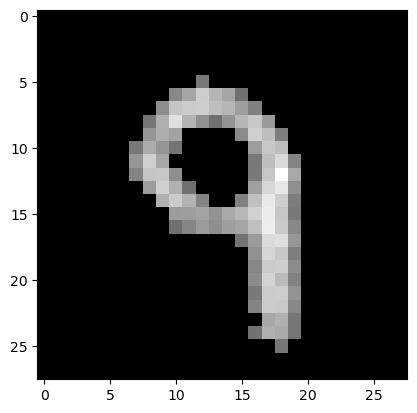

In [13]:
img_np, _ = train_dataset_noisy[0]
img_np = img_np.squeeze().numpy()

print(type(img_np))

min_image = cv2.GaussianBlur(img_np, (3, 3), 10) * 255.0
min_image[min_image < 100] = 0

plt.imshow(min_image, cmap='gray')

torch.Size([28, 28])


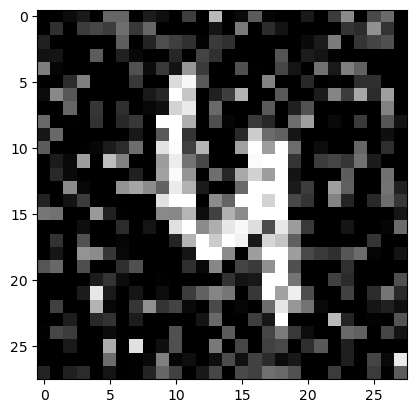

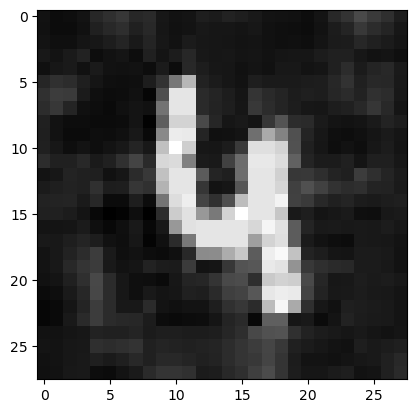

In [14]:
autoencoder_model.eval()
with torch.no_grad():
    i = 0
    img1, img2 = autoencoder_train_dataset[i]
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.squeeze().detach().cpu()

    out = autoencoder_model(img1).detach().squeeze().cpu()
    print(out.shape)

    plt.imshow(img2, cmap='gray')
    plt.show()

    plt.imshow(out, cmap='gray')
    plt.show()

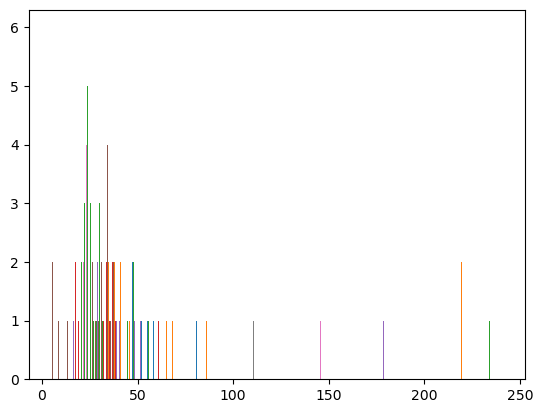

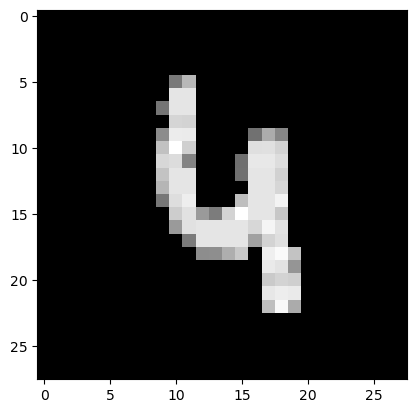

In [15]:
new_img = out * 255.0
plt.hist(new_img, bins=150)
plt.show()

new_img[new_img < 100] = 0
plt.imshow(new_img, cmap='gray')
plt.show()